In [108]:
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import torch_geometric.utils as utils
from torch_geometric.nn import GCNConv
from torch.nn import Linear

In [109]:
from torch_geometric.datasets import KarateClub
from torch_geometric.loader import DataLoader

### Experimenting with PyG basics

In [ ]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data_sample = Data(x=x, edge_index=edge_index)

In [ ]:
graph_nx = utils.to_networkx(data_sample)
nx.draw(graph_nx)

### Classifying basic GNN

In [110]:
dataset = KarateClub()

In [111]:
dataset.get(0).num_node_features

34

In [133]:
class GCNPure(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        
        return h
    
class GCNLinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

In [113]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

GCNPure(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 4)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


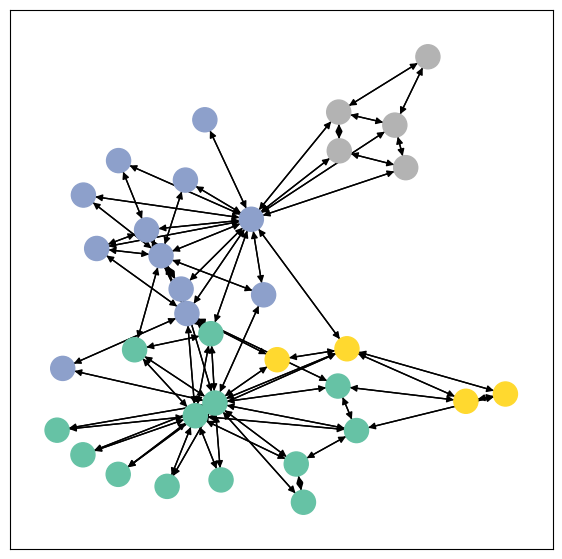

In [114]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCNPure().to(device)
print(model)

data = dataset[0]
data.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

visualize_graph(utils.to_networkx(data, to_undirected=False), color=data.y)

In [115]:
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

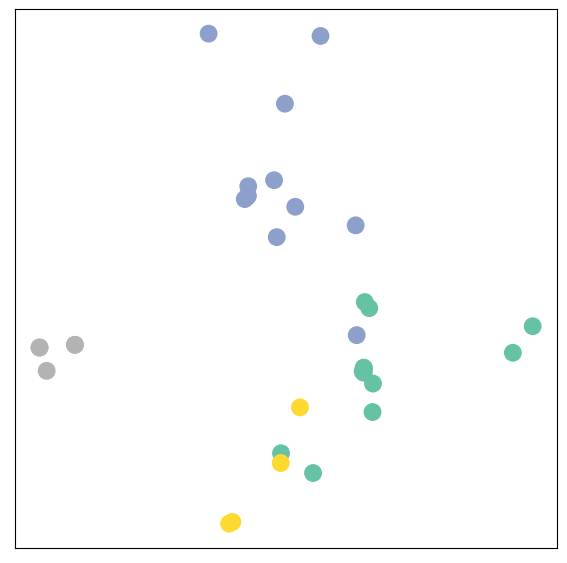

Final classified output


In [128]:
model.train()

for epoch in range(401):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    if epoch == 400:
        visualize_embedding(out, color=data.y)
        print('Final classified output')
    # train_mask takes care of train/val/tes splits
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [129]:
model.eval()

pred = model(data.x, data.edge_index).argmax(dim=1)

correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
total = data.train_mask.sum()


print(f'Accuracy: {int(correct)/int(total):>4f}')

print(pred)
print(data.y)

Accuracy: 1.000000
tensor([1, 1, 0, 1, 3, 3, 3, 1, 0, 0, 3, 1, 1, 0, 0, 0, 3, 1, 0, 0, 0, 1, 0, 2,
        2, 2, 0, 2, 0, 0, 0, 2, 0, 0])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


Trying a the worse classifier for comparison

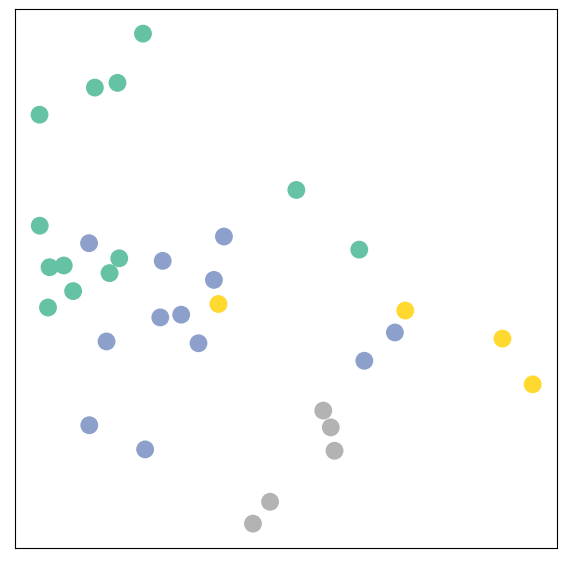

Final classified output


In [132]:
worse_model = GCNLinear()

worse_model.train()

out, h = None, None

for epoch in range(401):
    optimizer.zero_grad()
    out, h = worse_model(data.x, data.edge_index)        
    # train_mask takes care of train/val/tes splits
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
visualize_embedding(h, color=data.y)
print('Final classified output')

In [136]:
worse_model.eval()

pred, _ = worse_model(data.x, data.edge_index)
pred = pred.argmax(dim=1)

correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
total = data.train_mask.sum()

print(f'Accuracy: {int(correct)/int(total):>4f}')

print(pred)
print(data.y)

Accuracy: 0.250000
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
